In [1]:
from ddks.data import *
from ddks.data.openimages_dataset import LS
from ddks import methods
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
plt.style.use('ah')
plt.show()

In [2]:
methods_list = [methods.ddks_method,  methods.vdks_method, methods.rdks_method, methods.onedks_method,
                methods.hotelling_method, methods.kldiv_method]
datasets = [MM]#, MM]
sample_sizes = np.geomspace(2, 5000, 10).astype(int)
trials = 10

def time_method(_method, Dataset, dimension, parameter, sample_size=100, permutations=100):
    if Dataset.name == 'GVM':
        kwargs = dict(mean_p=0.5+parameter, mean_t=0.5)
    elif Dataset.name == 'GVS':
        kwargs = dict(std_p=0.5+parameter, std_t=0.5)
    elif Dataset.name == 'Skew':
        kwargs = dict(lambda_p=0.5+parameter, lambda_t=0.5)
    elif Dataset.name == 'MM':
        kwargs = dict(noise_fraction=parameter)
        
    _dataset = Dataset(dimension=dimension, sample_size=sample_size, **kwargs)
    p, t = next(_dataset)
    start = time.time()
    d = _method.score_function(p, t)
    end = time.time()
    return end - start


times = np.empty((len(methods_list), len(datasets), len(sample_sizes), trials))
for i, method in enumerate(methods_list):
    print(method.name)
    for j, dataset in enumerate(datasets):
        for k, sample_size in enumerate(tqdm.tqdm(sample_sizes)):
            for l in range(trials):
                times[i, j, k, l] = time_method(method, dataset, dimension=3, parameter=0.0, sample_size=sample_size)

pickle.dump(times, open('times.pkl', 'wb'))

 60%|██████    | 6/10 [00:00<00:00, 41.97it/s]

ddKS


 40%|████      | 4/10 [00:00<00:00, 26.62it/s]

vdKS


 30%|███       | 3/10 [00:00<00:00, 16.76it/s]

rdKS


 40%|████      | 4/10 [00:00<00:00, 35.14it/s]

OnedKS


  0%|          | 0/10 [00:00<?, ?it/s]

HotellingT2
KLDiv


100%|██████████| 10/10 [00:01<00:00,  5.23it/s]


In [ ]:
methods_list = [methods.ddks_method,  methods.vdks_method, methods.rdks_method, methods.onedks_method,
                methods.hotelling_method, methods.kldiv_method]
datasets = [MM]#, MM]
sample_sizes = np.geomspace(2, 10000, 10).astype(int)
trials = 10

def time_method(_method, Dataset, dimension, parameter, sample_size=100, permutations=100):
    if Dataset.name == 'GVM':
        kwargs = dict(mean_p=0.5+parameter, mean_t=0.5)
    elif Dataset.name == 'GVS':
        kwargs = dict(std_p=0.5+parameter, std_t=0.5)
    elif Dataset.name == 'Skew':
        kwargs = dict(lambda_p=0.5+parameter, lambda_t=0.5)
    elif Dataset.name == 'MM':
        kwargs = dict(noise_fraction=parameter)
        
    _dataset = Dataset(dimension=dimension, sample_size=sample_size, **kwargs)
    p, t = next(_dataset)
    start = time.time()
    d = _method.score_function(p, t)
    end = time.time()
    return end - start


times = np.empty((len(methods_list), len(datasets), len(sample_sizes), trials))
for i, method in enumerate(methods_list):
    print(method.name)
    for j, dataset in enumerate(datasets):
        for k, sample_size in enumerate(tqdm.tqdm(sample_sizes)):
            for l in range(trials):
                times[i, j, k, l] = time_method(method, dataset, dimension=3, parameter=0.0, sample_size=sample_size)

pickle.dump(times, open('times.pkl', 'wb'))

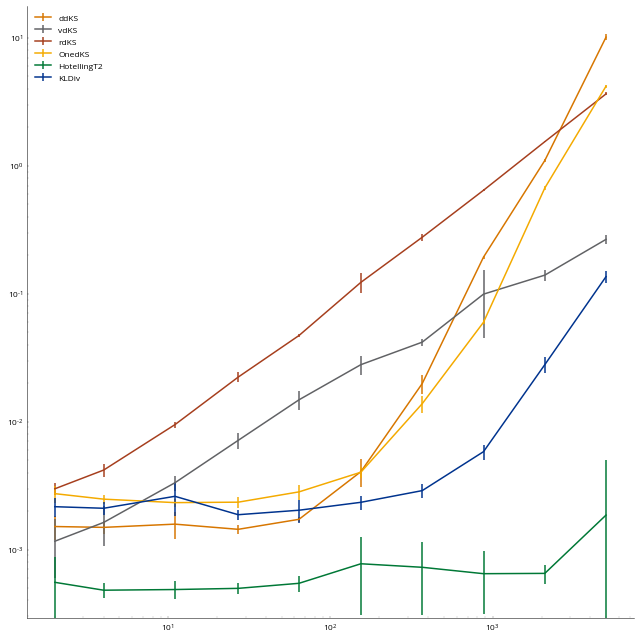

In [3]:
plt.figure(figsize=(9,9))

for i, method in enumerate(methods_list):
    for j, dataset in enumerate(datasets):
        mean_times = np.mean(times[i, j, ...], axis=1)
        std_times = np.std(times[i, j, ...], axis=1)
        plt.errorbar(sample_sizes, mean_times, yerr=std_times, label=method.name)
plt.loglog()
plt.legend()
plt.show()